In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip -q '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Data/test_images384x480.zip'

### Dependencies

In [0]:
#@title
# Dependencies
import os
import cv2
import math
import random
import shutil
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import exposure
import multiprocessing as mp
import albumentations as albu
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, fbeta_score
from keras import backend as K
from keras.utils import Sequence
from keras.layers import Input, average
from keras import optimizers, applications
from keras.models import Model, load_model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Required repositories
os.system('pip install segmentation-models')
os.system('pip install keras-rectified-adam')
os.system('pip install tta-wrapper')

from keras_radam import RAdam
import segmentation_models as sm
from tta_wrapper import tta_segmentation

# Misc
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(seed)
    
    
# Segmentation related
def rle_decode(mask_rle, shape=(1400, 2100)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')  # Needed to align to RLE direction

def rle_to_mask(rle_string, height, width):
    rows, cols = height, width
    
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1,2)
        img = np.zeros(rows*cols, dtype=np.uint8)
        for index, length in rle_pairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img
    
def get_mask_area(df, index, column_name, shape=(1400, 2100)):
    rle = df.loc[index][column_name]
    try:
        math.isnan(rle)
        np_mask = np.zeros((shape[0], shape[1], 3))
    except:
        np_mask = rle_to_mask(rle, shape[0], shape[1])
        np_mask = np.clip(np_mask, 0, 1)
        
    return int(np.sum(np_mask))

def np_resize(img, input_shape):
    """
    Reshape a numpy array, which is input_shape=(height, width), 
    as opposed to input_shape=(width, height) for cv2
    """
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    mask = np.zeros( width*height ).astype(np.uint8)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def dice_coefficient(y_true, y_pred):
    y_true = np.asarray(y_true).astype(np.bool)
    y_pred = np.asarray(y_pred).astype(np.bool)
    intersection = np.logical_and(y_true, y_pred)
    return (2. * intersection.sum()) / (y_true.sum() + y_pred.sum())

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
# Data pre-process
def preprocess_image(image_id, base_path, save_path, HEIGHT, WIDTH):
    image = cv2.imread(base_path + image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    cv2.imwrite(save_path + image_id, image)
    
def pre_process_set(df, preprocess_fn):
    n_cpu = mp.cpu_count()
    df_n_cnt = df.shape[0]//n_cpu
    pool = mp.Pool(n_cpu)
    
    dfs = [df.iloc[df_n_cnt*i:df_n_cnt*(i+1)] for i in range(n_cpu)]
    dfs[-1] = df.iloc[df_n_cnt*(n_cpu-1):]
    res = pool.map(preprocess_fn, [x_df for x_df in dfs])
    pool.close()
        
# def preprocess_data(df, HEIGHT=HEIGHT, WIDTH=WIDTH):
#     df = df.reset_index()
#     for i in range(df.shape[0]):
#         item = df.iloc[i]
#         image_id = item['image']
#         item_set = item['set']
#         if item_set == 'train':
#             preprocess_image(image_id, train_base_path, train_images_dest_path, HEIGHT, WIDTH)
#         if item_set == 'validation':
#             preprocess_image(image_id, train_base_path, validation_images_dest_path, HEIGHT, WIDTH)
#         if item_set == 'test':
#             preprocess_image(image_id, test_base_path, test_images_dest_path, HEIGHT, WIDTH)

# Model evaluation
def get_metrics_classification(df, preds, label_columns, threshold_list=[.5, .5, .5, .5], show_report=True):
  accuracy = []
  precision = []
  recall = []
  f_score = []
  for index, label in enumerate(label_columns):
    print('Metrics for: %s' % label)
    if show_report:
      print(classification_report(df[label], (preds[:,index] > best_tresholds[index]).astype(int), output_dict=False))
    metrics = classification_report(df[label], (preds[:,index] > best_tresholds[index]).astype(int), output_dict=True)
    accuracy.append(metrics['accuracy'])
    precision.append(metrics['1']['precision'])
    recall.append(metrics['1']['recall'])
    f_score.append(metrics['1']['f1-score'])
    
  print('Averaged accuracy:  %.2f' % np.mean(accuracy))
  print('Averaged precision: %.2f' % np.mean(precision))
  print('Averaged recall:    %.2f' % np.mean(recall))
  print('Averaged f_score:   %.2f' % np.mean(f_score))

def plot_metrics(history, metric_list=['loss', 'dice_coef'], figsize=(22, 14)):
    fig, axes = plt.subplots(len(metric_list), 1, sharex='col', figsize=(22, len(metric_list)*4))
    axes = axes.flatten()
    
    for index, metric in enumerate(metric_list):
        axes[index].plot(history[metric], label='Train %s' % metric)
        axes[index].plot(history['val_%s' % metric], label='Validation %s' % metric)
        axes[index].legend(loc='best')
        axes[index].set_title(metric)

    plt.xlabel('Epochs')
    sns.despine()
    plt.show()

# Model post process
def post_process(probability, threshold=0.5, min_size=10000):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros(probability.shape, np.float32)
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
    return predictions

# Prediction evaluation
def get_metrics(model, target_df, df, df_images_dest_path, label_columns, tresholds, min_mask_sizes, N_CLASSES=4, seed=0, preprocessing=None, adjust_fn=None, adjust_param=None, set_name='Complete set', column_names=['Class', 'Dice', 'Dice Post']):
    metrics = []

    for class_name in label_columns:
        metrics.append([class_name, 0, 0])

    metrics_df = pd.DataFrame(metrics, columns=column_names)
    
    for i in range(0, df.shape[0], 100):
        batch_idx = list(range(i, min(df.shape[0], i + 100)))
        batch_set = df[batch_idx[0]: batch_idx[-1]+1]
        ratio = len(batch_set) / len(df)

        generator = DataGenerator(
                      directory=df_images_dest_path,
                      dataframe=batch_set,
                      target_df=target_df,
                      batch_size=len(batch_set), 
                      target_size=model.input_shape[1:3],
                      n_channels=model.input_shape[3],
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      adjust_fn=adjust_fn,
                      adjust_param=adjust_param,
                      seed=seed,
                      mode='fit',
                      shuffle=False)

        x, y = generator.__getitem__(0)
        preds = model.predict(x)
        
        for class_index in range(N_CLASSES):
            class_score = []
            class_score_post = []
            mask_class = y[..., class_index]
            pred_class = preds[..., class_index]
            for index in range(len(batch_idx)):
                sample_mask = mask_class[index, ]
                sample_pred = pred_class[index, ]
                sample_pred_post = post_process(sample_pred, threshold=tresholds[class_index], min_size=min_mask_sizes[class_index])
                if (sample_mask.sum() == 0) & (sample_pred.sum() == 0):
                    dice_score = 1.
                else:
                    dice_score = dice_coefficient(sample_pred, sample_mask)
                if (sample_mask.sum() == 0) & (sample_pred_post.sum() == 0):
                    dice_score_post = 1.
                else:
                    dice_score_post = dice_coefficient(sample_pred_post, sample_mask)
                class_score.append(dice_score)
                class_score_post.append(dice_score_post)
            metrics_df.loc[metrics_df[column_names[0]] == label_columns[class_index], column_names[1]] += np.mean(class_score) * ratio
            metrics_df.loc[metrics_df[column_names[0]] == label_columns[class_index], column_names[2]] += np.mean(class_score_post) * ratio

    metrics_df = metrics_df.append({column_names[0]:set_name, column_names[1]:np.mean(metrics_df[column_names[1]].values), column_names[2]:np.mean(metrics_df[column_names[2]].values)}, ignore_index=True).set_index(column_names[0])
    
    return metrics_df

def get_metrics_ensemble(model_list, target_df, df, df_images_dest_path, label_columns, tresholds, min_mask_sizes, N_CLASSES=4, seed=0, preprocessing=None, adjust_fn=None, adjust_param=None, set_name='Complete set', column_names=['Class', 'Dice', 'Dice Post']):
    metrics = []

    for class_name in label_columns:
        metrics.append([class_name, 0, 0])

    metrics_df = pd.DataFrame(metrics, columns=column_names)
    
    for i in range(0, df.shape[0], 100):
        batch_idx = list(range(i, min(df.shape[0], i + 100)))
        batch_set = df[batch_idx[0]: batch_idx[-1]+1]
        ratio = len(batch_set) / len(df)
        
        target_size = model_list[0].input_shape[1:3]
        n_channels = model_list[0].input_shape[3]

        generator = DataGenerator(
                      directory=df_images_dest_path,
                      dataframe=batch_set,
                      target_df=target_df,
                      batch_size=len(batch_set), 
                      target_size=target_size,
                      n_channels=n_channels,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      adjust_fn=adjust_fn,
                      adjust_param=adjust_param,
                      seed=seed,
                      mode='fit',
                      shuffle=False)

        x, y = generator.__getitem__(0)
        preds = np.zeros((len(batch_set), *target_size, N_CLASSES))
        for model in model_list:
            preds += model.predict(x)

        preds /= len(model_list)
        
        for class_index in range(N_CLASSES):
            class_score = []
            class_score_post = []
            mask_class = y[..., class_index]
            pred_class = preds[..., class_index]
            for index in range(len(batch_idx)):
                sample_mask = mask_class[index, ]
                sample_pred = pred_class[index, ]
                sample_pred_post = post_process(sample_pred, threshold=tresholds[class_index], min_size=min_mask_sizes[class_index])
                if (sample_mask.sum() == 0) & (sample_pred.sum() == 0):
                    dice_score = 1.
                else:
                    dice_score = dice_coefficient(sample_pred, sample_mask)
                if (sample_mask.sum() == 0) & (sample_pred_post.sum() == 0):
                    dice_score_post = 1.
                else:
                    dice_score_post = dice_coefficient(sample_pred_post, sample_mask)
                class_score.append(dice_score)
                class_score_post.append(dice_score_post)
            metrics_df.loc[metrics_df[column_names[0]] == label_columns[class_index], column_names[1]] += np.mean(class_score) * ratio
            metrics_df.loc[metrics_df[column_names[0]] == label_columns[class_index], column_names[2]] += np.mean(class_score_post) * ratio

    metrics_df = metrics_df.append({column_names[0]:set_name, column_names[1]:np.mean(metrics_df[column_names[1]].values), column_names[2]:np.mean(metrics_df[column_names[2]].values)}, ignore_index=True).set_index(column_names[0])
    
    return metrics_df

def inspect_predictions(df, image_ids, images_dest_path, pred_col=None, label_col='EncodedPixels', title_col='Image_Label', img_shape=(525, 350), figsize=(22, 6)):
    if pred_col:
        for sample in image_ids:
            sample_df = df[df['image'] == sample]
            fig, axes = plt.subplots(2, 5, figsize=figsize)
            img = cv2.imread(images_dest_path + sample_df['image'].values[0])
            img = cv2.resize(img, img_shape)
            axes[0][0].imshow(img)
            axes[1][0].imshow(img)
            axes[0][0].set_title('Label', fontsize=16)
            axes[1][0].set_title('Predicted', fontsize=16)
            axes[0][0].axis('off')
            axes[1][0].axis('off')
            for i in range(4):
                mask = sample_df[label_col].values[i]
                try:
                    math.isnan(mask)
                    mask = np.zeros((img_shape[1], img_shape[0]))
                except:
                    mask = rle_decode(mask)
                axes[0][i+1].imshow(mask)
                axes[1][i+1].imshow(rle2mask(sample_df[pred_col].values[i], img.shape))
                axes[0][i+1].set_title(sample_df[title_col].values[i], fontsize=18)
                axes[1][i+1].set_title(sample_df[title_col].values[i], fontsize=18)
                axes[0][i+1].axis('off')
                axes[1][i+1].axis('off')
    else:
        for sample in image_ids:
            sample_df = df[df['image'] == sample]
            fig, axes = plt.subplots(1, 5, figsize=figsize)
            img = cv2.imread(images_dest_path + sample_df['image'].values[0])
            img = cv2.resize(img, img_shape)
            axes[0].imshow(img)
            axes[0].set_title('Original', fontsize=16)
            axes[0].axis('off')
            for i in range(4):
                mask = sample_df[label_col].values[i]
                try:
                    math.isnan(mask)
                    mask = np.zeros((img_shape[1], img_shape[0]))
                except:
                    mask = rle_decode(mask, shape=(img_shape[1], img_shape[0]))
                axes[i+1].imshow(mask)
                axes[i+1].set_title(sample_df[title_col].values[i], fontsize=18)
                axes[i+1].axis('off')

def inspect_predictions_class(df, image_ids, images_dest_path, pred_col=None, label_col='EncodedPixels', title_col='Image_Label', img_shape=(525, 350), figsize=(22, 6)):
  for sample in image_ids:
    sample_df = df[df['image'] == sample]
    fig, axes = plt.subplots(2, 5, figsize=figsize)
    img = cv2.imread(images_dest_path + sample_df['image'].values[0])
    img = cv2.resize(img, img_shape)
    axes[0][0].imshow(img)
    axes[1][0].imshow(img)
    axes[0][0].set_title('Label', fontsize=16)
    axes[1][0].set_title('Predicted', fontsize=16)
    axes[0][0].axis('off')
    axes[1][0].axis('off')
    for i in range(4):
        mask = sample_df[label_col].values[i]
        pred_mask = sample_df[pred_col].values[i]
        try:
            math.isnan(mask)
            mask = np.zeros((img_shape[1], img_shape[0]))
        except:
            mask = rle_decode(mask)            
        try:
            math.isnan(pred_mask)
            pred_mask = np.zeros((img_shape[1], img_shape[0]))
        except:
            pred_mask = rle_decode(pred_mask)
        axes[0][i+1].imshow(mask)
        axes[1][i+1].imshow(pred_mask)
        axes[0][i+1].set_title(sample_df[title_col].values[i], fontsize=18)
        axes[1][i+1].set_title(sample_df[title_col].values[i], fontsize=18)
        axes[0][i+1].axis('off')
        axes[1][i+1].axis('off')

# Model tunning
def classification_tunning(y_true, y_pred, label_columns, beta=0.25, threshold_grid=np.arange(0, 1, .01), column_names=['Class', 'Threshold', 'Score'], print_score=True):
  metrics = []
  for label in label_columns:
      for threshold in threshold_grid:
          metrics.append([label, threshold, 0])

  metrics_df = pd.DataFrame(metrics, columns=column_names)
  for index, label in enumerate(label_columns):
      for thr in threshold_grid:
          metrics_df.loc[(metrics_df[column_names[0]] == label) & (metrics_df[column_names[1]] == thr) , column_names[2]] = fbeta_score(y_true[:,index], (y_pred[:,index] > thr).astype(int), beta=beta)

  best_tresholds = []
  best_scores = []
  for index, label in enumerate(label_columns):
    metrics_df_lbl = metrics_df[metrics_df[column_names[0]] == label_columns[index]]
    optimal_values_lbl = metrics_df_lbl.loc[metrics_df_lbl[column_names[2]].idxmax()].values
    best_tresholds.append(optimal_values_lbl[1])
    best_scores.append(optimal_values_lbl[2])

  if print_score:
    for index, label in enumerate(label_columns):
      print('%s treshold=%.2f Score=%.3f' % (label, best_tresholds[index], best_scores[index]))

  return best_tresholds

def segmentation_tunning(model, target_df, df, df_images_dest_path, label_columns, mask_grid, threshold_grid=np.arange(0, 1, .01), N_CLASSES=4, preprocessing=None, adjust_fn=None, adjust_param=None, seed=0, column_names=['Class', 'Threshold', 'Mask size', 'Dice'], print_score=True):
    metrics = []

    for label in label_columns:
        for threshold in threshold_grid:
            for mask_size in mask_grid:
                metrics.append([label, threshold, mask_size, 0])

    metrics_df = pd.DataFrame(metrics, columns=column_names)

    for i in range(0, df.shape[0], 100):
        batch_idx = list(range(i, min(df.shape[0], i + 100)))
        batch_set = df[batch_idx[0]: batch_idx[-1]+1]
        ratio = len(batch_set) / len(df)

        generator = DataGenerator(
                      directory=df_images_dest_path,
                      dataframe=batch_set,
                      target_df=target_df,
                      batch_size=len(batch_set), 
                      target_size=model.input_shape[1:3],
                      n_channels=model.input_shape[3],
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      adjust_fn=adjust_fn,
                      adjust_param=adjust_param,
                      seed=seed,
                      mode='fit',
                      shuffle=False)

        x, y = generator.__getitem__(0)
        preds = model.predict(x)

        for class_index, label in enumerate(label_columns):
            class_score = []
            label_class = y[..., class_index]
            pred_class = preds[..., class_index]
            for threshold in threshold_grid:
                for mask_size in mask_grid:
                    mask_score = []
                    for index in range(len(batch_idx)):
                        label_mask = label_class[index, ]
                        pred_mask = pred_class[index, ]
                        pred_mask = post_process(pred_mask, threshold=threshold, min_size=mask_size)
                        dice_score = dice_coefficient(pred_mask, label_mask)
                        if (pred_mask.sum() == 0) & (label_mask.sum() == 0):
                            dice_score = 1.
                        mask_score.append(dice_score)
                    metrics_df.loc[(metrics_df[column_names[0]] == label) & (metrics_df[column_names[1]] == threshold) & 
                                   (metrics_df[column_names[2]] == mask_size), column_names[3]] += np.mean(mask_score) * ratio
                    
    best_tresholds = []
    best_masks = []
    best_dices = []
    for index, label in enumerate(label_columns):
        metrics_df_lbl = metrics_df[metrics_df[column_names[0]] == label_columns[index]]
        optimal_values_lbl = metrics_df_lbl.loc[metrics_df_lbl[column_names[3]].idxmax()].values
        best_tresholds.append(optimal_values_lbl[1])
        best_masks.append(optimal_values_lbl[2])
        best_dices.append(optimal_values_lbl[3])

    if print_score:
        for index, name in enumerate(label_columns):
            print('%s treshold=%.2f mask size=%d Dice=%.3f' % (name, best_tresholds[index], best_masks[index], best_dices[index]))
            
    return best_tresholds, best_masks

# Model utils
def ensemble_models(input_shape, model_list, rename_model=False):
    if rename_model:
        for index, model in enumerate(model_list):
            model.name = 'ensemble_' + str(index) + '_' + model.name
            for layer in model.layers:
                layer.name = 'ensemble_' + str(index) + '_' + layer.name
        
    inputs = Input(shape=input_shape)
    outputs = average([model(inputs) for model in model_list])
    
    return Model(inputs=inputs, outputs=outputs)

# Data generator
class DataGenerator(Sequence):
    def __init__(self, dataframe, directory, batch_size, n_channels, target_size,  n_classes, 
                 mode='fit', target_df=None, shuffle=True, preprocessing=None, augmentation=None, adjust_fn=None, adjust_param=None, seed=0):
        
        self.batch_size = batch_size
        self.dataframe = dataframe
        self.mode = mode
        self.directory = directory
        self.target_df = target_df
        self.target_size = target_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.preprocessing = preprocessing
        self.augmentation = augmentation
        self.adjust_fn = adjust_fn
        self.adjust_param = adjust_param
        self.seed = seed
        self.mask_shape = (1400, 2100)
        self.list_IDs = self.dataframe.index
        
        if self.seed is not None:
            np.random.seed(self.seed)
        
        self.on_epoch_end()

    def __len__(self):
        return len(self.list_IDs) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            Y = self.__generate_Y(list_IDs_batch)
            
            if self.augmentation:
                X, Y = self.__augment_batch(X, Y)
            
            return X, Y
        
        elif self.mode == 'predict':
            return X
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        X = np.empty((self.batch_size, *self.target_size, self.n_channels))
        
        for i, ID in enumerate(list_IDs_batch):
            img_name = self.dataframe['image'].loc[ID]
            img_path = self.directory + img_name
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if (not self.adjust_fn is None) & (not self.adjust_param is None):
                img = self.adjust_fn(img, self.adjust_param)

            if self.preprocessing:
                img = self.preprocessing(img)
                
            X[i,] = img

        return X
    
    def __generate_Y(self, list_IDs_batch):
        Y = np.empty((self.batch_size, *self.target_size, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            img_name = self.dataframe['image'].loc[ID]
            image_df = self.target_df[self.target_df['image'] == img_name]
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.mask_shape, reshape=self.target_size)
            Y[i, ] = masks

        return Y
    
    def __augment_batch(self, X_batch, Y_batch):
        for i in range(X_batch.shape[0]):
            X_batch[i, ], Y_batch[i, ] = self.__random_transform(X_batch[i, ], Y_batch[i, ])
        
        return X_batch, Y_batch
    
    def __random_transform(self, X, Y):
        composed = self.augmentation(image=X, mask=Y)
        X_aug = composed['image']
        Y_aug = composed['mask']
        
        return X_aug, Y_aug

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

In [0]:
base_path = '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/'
data_path = base_path + 'Data/'
segmentation_model_base_path = base_path + 'Models/files/segmentation/'
classification_model_base_path = base_path + 'Models/files/classification/'
segmentation_model_path_list = [segmentation_model_base_path + '42-[K-Fold1]unet_densenet169_384x480.h5', segmentation_model_base_path + '42-[K-Fold2]unet_densenet169_384x480.h5', 
                                segmentation_model_base_path + '42-[K-Fold3]unet_densenet169_384x480.h5', segmentation_model_base_path + '42-[K-Fold4]unet_densenet169_384x480.h5', 
                                segmentation_model_base_path + '42-[K-Fold5]unet_densenet169_384x480.h5']
classification_model_path = classification_model_base_path + '8-resnet50_224x224.h5'
submission_base_path = data_path + 'submissions/inference/'
test_path = data_path + 'sample_submission.csv'
test_images_path = 'test_images384x480/'

### Load data

In [0]:
submission = pd.read_csv(test_path)
print('Test samples:', len(submission))

# Preprocecss data
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])

display(test.head())

Test samples: 14792


,image
0,002f507.jpg
1,0035ae9.jpg
2,0038327.jpg
3,004f759.jpg
4,005ba08.jpg


# Model parameters

In [0]:
BACKBONE = 'densenet169'
SEG_HEIGHT = 384
SEG_WIDTH = 480
CLASS_HEIGHT = 224
CLASS_WIDTH = 224
CHANNELS = 3
N_CLASSES = 4
label_columns=['Fish', 'Flower', 'Gravel', 'Sugar']
best_tresholds_class = [0.85, 0.79, 0.92, 0.82]
best_tresholds_seg = [0.45, 0.4, 0.5, 0.3]
best_masks_seg = [22500, 20000, 22500, 12500]

model_name = '14-[seg]-[5-fold]42-unet_densenet169_384x480[class]8-resnet50_224x224'
submission_path = submission_base_path + '%s_submission.csv' % (model_name)
submission_post_path = submission_base_path + '%s_submission_post.csv' % (model_name)
submission_post_class_path = submission_base_path + '%s_submission_post_class.csv' % (model_name)
submission_post_tta_path = submission_base_path + '%s_submission_post_tta.csv' % (model_name)

In [0]:
preprocessing = sm.get_preprocessing(BACKBONE)

# Model

In [0]:
classification_model = load_model(classification_model_path, custom_objects={'RAdam':RAdam})

segmentation_model_list = []
for model_path in segmentation_model_path_list:
    segmentation_model_list.append(load_model(model_path, custom_objects={'RAdam':RAdam, 'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score}))

segmentation_model = ensemble_models((SEG_HEIGHT, SEG_WIDTH, CHANNELS), segmentation_model_list, rename_model=True)
segmentation_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 480, 3)  0                                            
__________________________________________________________________________________________________
ensemble_0_model_2 (Model)      (None, 384, 480, 4)  19520260    input_1[0][0]                    
__________________________________________________________________________________________________
ensemble_1_model_1 (Model)      (None, 384, 480, 4)  19520260    input_1[0][0]                    
__________________________________________________________________________________________________
ensemble_2_model_1 (Model)      (None, 384, 480, 4)  19520260    input_1[0][0]                    
____________________________________________________________________________________________

### Classification data generator

In [0]:
test_datagen=ImageDataGenerator(rescale=1./255.)

classification_test_generator=test_datagen.flow_from_dataframe(
                                           dataframe=test,
                                           directory=test_images_path,
                                           x_col="image",
                                           target_size=(CLASS_HEIGHT, CLASS_WIDTH),
                                           class_mode=None,
                                           batch_size=1,
                                           shuffle=False,
                                           seed=seed)

Found 3698 validated image filenames.


# Apply segmentation model to test set

In [0]:
#@title
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(SEG_HEIGHT, SEG_WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = segmentation_model.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32') 
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post'] = pred_rles_post
        ###
        
        test_df.append(image_df)

X_test = pd.concat(test_df)

# Apply classifcation model to test set

In [0]:
test_class_preds = classification_model.predict_generator(classification_test_generator)

for index in range(len(label_columns)):
  test_class_preds[:,index] = (test_class_preds[:,index] > best_tresholds_class[index]).astype(int)
  
X_test['has_mask'] = test_class_preds.reshape(test_class_preds.shape[0]*N_CLASSES)
X_test['EncodedPixels_post_class'] = X_test.apply(lambda row: row['EncodedPixels'] if row['has_mask'] == 1 else np.nan, axis=1)

# Using TTA Wrapper

In [0]:
segmentation_model_tta = tta_segmentation(segmentation_model, h_flip=True, v_flip=True, merge='mean')
segmentation_model_tta.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (1, 384, 480, 3)          0         
_________________________________________________________________
repeat_1 (Repeat)            (4, 384, 480, 3)          0         
_________________________________________________________________
tta_1 (TTA)                  (4, 384, 480, 3)          0         
_________________________________________________________________
model_1 (Model)              multiple                  97601300  
_________________________________________________________________
tta_2 (TTA)                  (4, 384, 480, 4)          0         
_________________________________________________________________
merge_1 (Merge)              (1, 384, 480, 4)          0         
Total params: 97,601,300
Trainable params: 96,799,380
Non-trainable params: 801,920
________________________________________

# Apply segmentation model to test set (TTA)

In [0]:
#@title
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(SEG_HEIGHT, SEG_WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = segmentation_model_tta.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels_tta'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32')
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post_tta'] = pred_rles_post
        
        test_df.append(image_df)

X_test_tta = pd.concat(test_df)

## Inspecting some of the test set predictions

### Without post-process

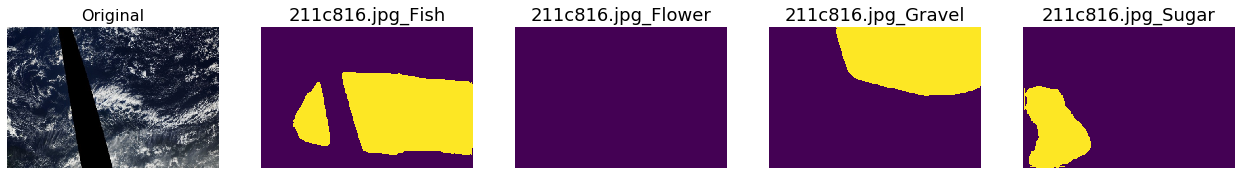

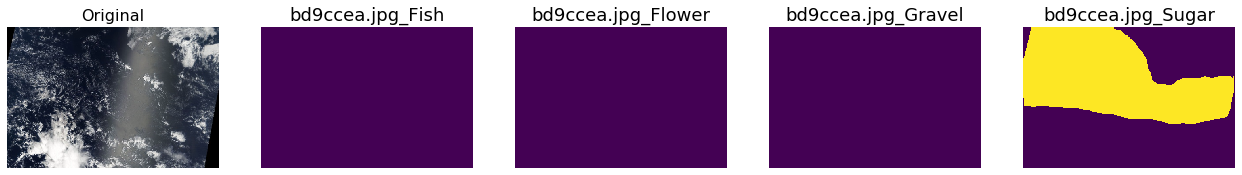

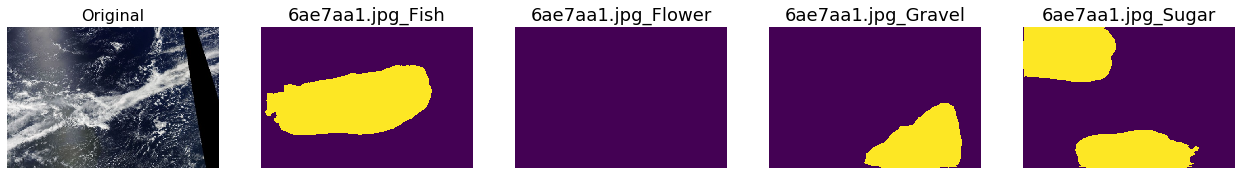

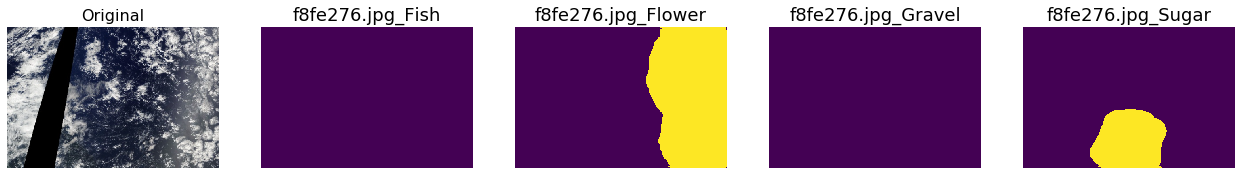

In [0]:
images_to_inspect_test =  np.random.choice(X_test['image'].unique(), 4, replace=False)
inspect_predictions(X_test, images_to_inspect_test, test_images_path)

### With post-process

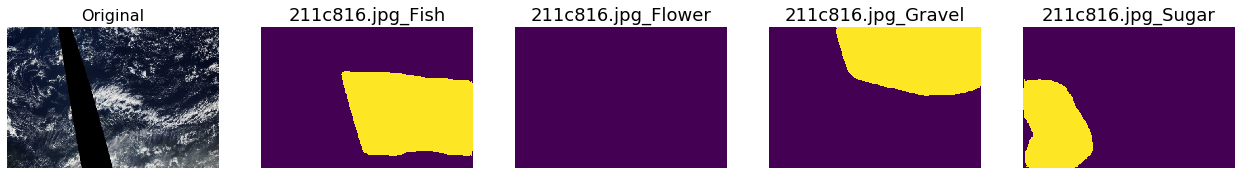

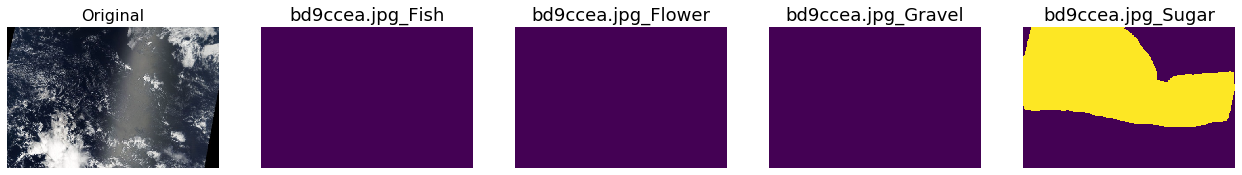

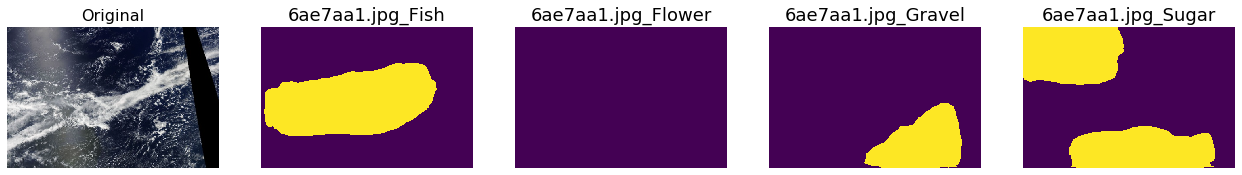

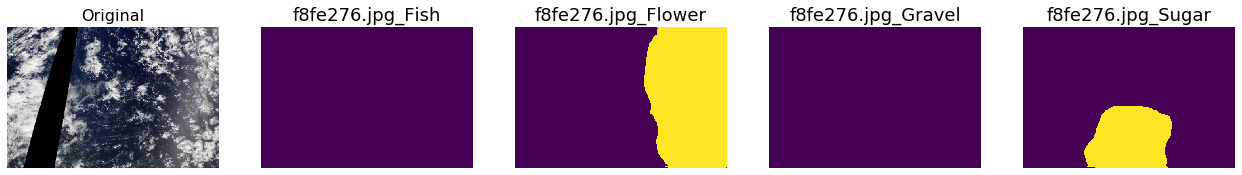

In [0]:
inspect_predictions(X_test, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post')

### With post-process and mask classification

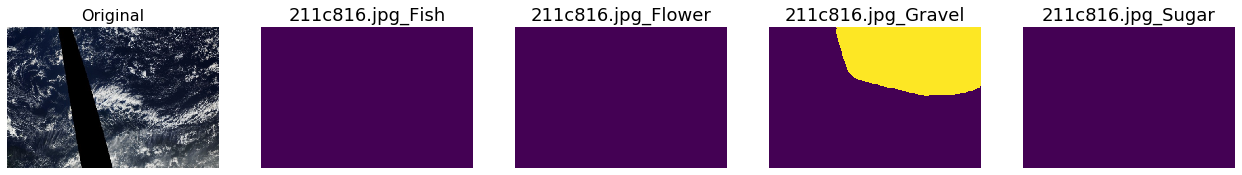

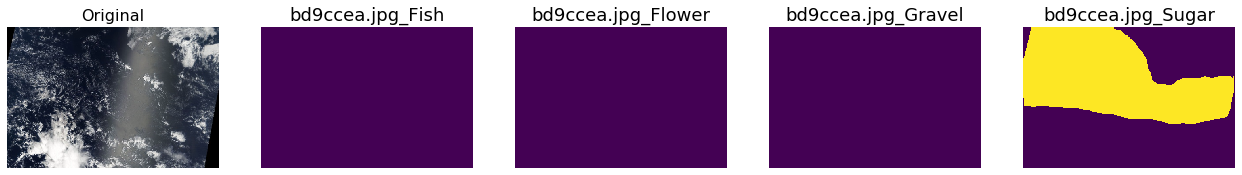

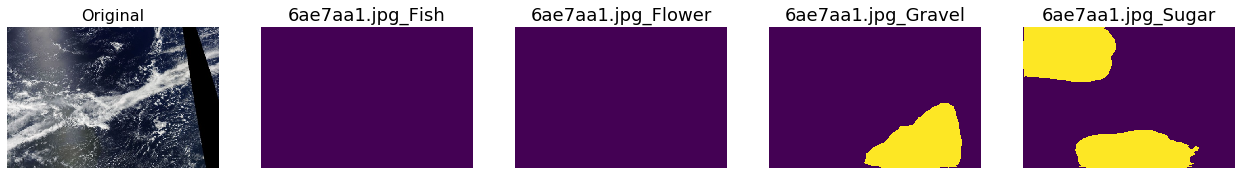

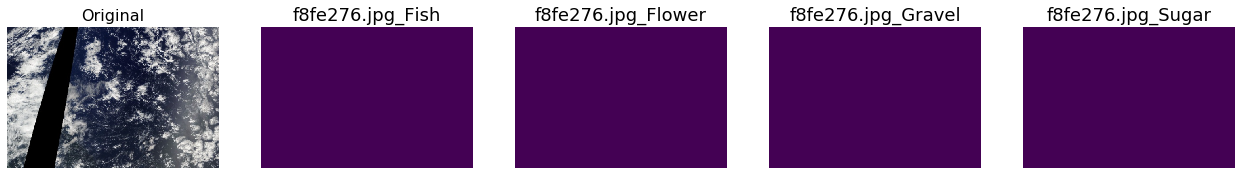

In [0]:
inspect_predictions(X_test, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post_class')

### With post-process and TTA

In [0]:
inspect_predictions(X_test_tta, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post_tta')

### Regular submission

In [0]:
submission_df = X_test[['Image_Label' ,'EncodedPixels']]
submission_df.to_csv(submission_path, index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,4 342 354 342 703 346 1051 348 1401 349 1751 5...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,127946 9 128290 17 128636 22 128985 25 129334 ...


### Submission with post processing

In [0]:
submission_df_post = X_test[['Image_Label' ,'EncodedPixels_post']]
submission_df_post.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post.to_csv(submission_post_path, index=False)
display(submission_df_post.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,4 342 354 342 703 346 1051 348 1401 349 1751 5...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


### Submission with post processing and mask classification

In [0]:
submission_df_post = X_test[['Image_Label' ,'EncodedPixels_post_class']]
submission_df_post.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post.to_csv(submission_post_class_path, index=False)
display(submission_df_post.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,NaN
1,002f507.jpg_Flower,NaN
2,002f507.jpg_Gravel,4 342 354 342 703 346 1051 348 1401 349 1751 5...
3,002f507.jpg_Sugar,NaN
4,0035ae9.jpg_Fish,NaN


### Submission with post processing and TTA

In [0]:
submission_df_post_class = X_test_tta[['Image_Label' ,'EncodedPixels_post_tta']]
submission_df_post_class.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post_class.to_csv(submission_post_tta_path, index=False)
display(submission_df_post_class.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,3 345 353 345 702 347 1051 348 1401 349 1751 5...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,
